In [ ]:
import os.path as osp
import os, glob, shutil

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Downloading the data

Note: you should fill in `source_name` and `source_path` based on the correct name and URL for the larger dataset(s). `original_tool_image.zip` is done for you.

In [ ]:
source_name = "convertible_images.zip"
source_path = "https://www.dropbox.com/s/0voxu5htke3v6ip/Convertible.zip"

In [5]:
import os
if not os.path.exists('./original_tool_image.zip'):
  ! wget -O original_tool_image.zip https://www.dropbox.com/s/pha9yzdfkmzoqob/original_tool_images.zip?dl=0
if not os.path.exists(source_name):
  ! wget -O $source_name $source_path

# 0. Setup

## Git Clone

### From Source

In [6]:
! rm -rf -- GLAMOR

In [7]:
! git clone -b master https://github.com/asuprem/GLAMOR

Cloning into 'GLAMOR'...
remote: Enumerating objects: 8032, done.
remote: Counting objects: 100% (2519/2519), done.
remote: Compressing objects: 100% (801/801), done.
remote: Total 8032 (delta 1573), reused 2349 (delta 1447), pack-reused 5513
Receiving objects: 100% (8032/8032), 2.18 MiB | 16.29 MiB/s, done.
Resolving deltas: 100% (5274/5274), done.


In [8]:
!pip install -e GLAMOR/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/GLAMOR
     |████████████████████████████████| 1.3 MB 30.8 MB/s 
  Running setup.py develop for ednaml


###  From PyPi

In [9]:
#! python -V

In [10]:
#! pip3 install --pre ednaml==0.1.4

# ----------- Restart Notebook to Finish EdnaML Installation ----------------

# 1 Building the Crawler

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import ednaml
import glob, os
import pandas as pd
import re
from ednaml.core import EdnaDeploy, EdnaML
torch.__version__

'1.12.1+cu113'

## 1.1 Crawler Extractors

In [3]:
class VehicleInfo:
  def __init__(self, vehicle_type=None, color=None, year=None, make=None, model=None, img_path=None):
    self.vehicle_type = vehicle_type
    self.color = color
    self.year = year
    self.make = make
    self.model = model
    self.img_path = img_path
  

  def get_info_tuple(self):
    return [self.vehicle_type, self.color, self.year, self.make, self.model, self.img_path]
  
  def to_dict(self):
    return {
        "type": self.vehicle_type,
        "color": self.color,
        "year": self.year,
        "make": self.make,
        "model": self.model,
        "img_path": self.img_path
    }  

In [4]:
class ModelExtractor:
  IMG_EXTENSIONS = [
      ".jpeg", ".jpg", ".png"
  ]
  @classmethod
  def extract(cls, vehicle_type, year, make, string):
    
    for extension in cls.IMG_EXTENSIONS:
      string = string.replace(extension, "")

    model_splits = string.split("__")[0].split("_")
    model = []
    for idx, model_split in enumerate(model_splits):
      if idx == len(model_splits) - 1 and model_split.isnumeric() and "__" not in string:
        continue
      
      model.append(model_split)
    
    return vehicle_type, year, make, " ".join(model)

class MakeExtractor:

  @classmethod
  def split_based_on_caps(cls, string):
    return re.findall('[A-Z][^A-Z0-9_]*', string)

  @classmethod
  def extract(cls, vehicle_type, year, string):
    split_on_capitalized_letters = cls.split_based_on_caps(string)

    multiword_makes = {
        "LandRover": "Land Rover", 
        "Mercedes-Benz": "Mercedes Benz",
        "BMW": "BMW"
    }

    for multiword_make, mapped_make in multiword_makes.items():
      if string.startswith(multiword_make):
        make = mapped_make
        remaining_str = string.replace(multiword_make, "").lstrip()
        break

    else:
      make = split_on_capitalized_letters[0]
      remaining_str = string.replace(make, "").lstrip()

    return vehicle_type, year, make, remaining_str

class YearExtractor:

  @classmethod
  def extract(cls, vehicle_type, string):
    year, remaining_str = string.split("_", 1)
    return vehicle_type, year, remaining_str


class TypeExtractor:

  @classmethod
  def extract(cls, string):
    vehicle_type, remaining_str = string.split("_", 1)
    return vehicle_type, remaining_str


class Extractor:

  @classmethod
  def extract(cls, string):
    extracted_parts = []
    remaining_string = string

    for extractor_cls in [TypeExtractor, YearExtractor, MakeExtractor, ModelExtractor]:
      output = extractor_cls.extract(*extracted_parts, remaining_string)
      remaining_string = output[-1]
      extracted_parts = output[ : -1]
    
    vehicle_type, year, make, model = output
    return VehicleInfo(vehicle_type=vehicle_type, year=year, make=make, model=model)


## 1.2 Crawler class definition

In [5]:
# Here we define our custom model class
from ednaml.crawlers import Crawler
from zipfile import ZipFile # might be useful in unzipping!
import traceback

class CarZamCrawler(Crawler):
  DATASET_EXTRACTION_DIR = "/Users/deepakchalliyil/PycharmProjects/carzam/images"

  def __init__(self, logger, file_name = "original_tool_images.zip", **kwargs): # Add your own arguments if needed!
    self.metadata = {}
    self.log_level = kwargs.get("log_level", "info")
    self.random_seed = kwargs.get("seed", 2321412)
    self.train_split_frac = kwargs.get("train_split_frac", 0.8)
    self.test_split_frac = kwargs.get("test_split_frac", 0.1)
    self.validation_split_frac = kwargs.get("validation_split_frac", 0.1)
    
    if self.train_split_frac + self.test_split_frac + self.validation_split_frac != 1:
      raise AssertionError(f'Train/Split/Validation split fractions should sum upto 1!')

    self.metadata["train"] = {}
    self.metadata["test"] = {}
    self.metadata["val"] = {}
    self.metadata["train"]["crawl"] = []  # <------ THIS NEEDS TO BE POPULATED
    self.metadata["test"]["crawl"] = []   # <------ THIS NEEDS TO BE POPULATED
    self.metadata["val"]["crawl"] = []    # <------ THIS NEEDS TO BE POPULATED
    
    # YOUR CODE HERE ------ POPULATE self.classes and self.metadata's empty lists ---
    self.file_name = file_name

    self.vehicle_info_list, self.vehicle_df = self.parse_data()
    self.encoded_df, self.reverse_lookup_dict = self.factorize_labels(self.vehicle_df)
    
    self.shuffled_df = self.encoded_df.sample(frac=1, random_state=self.random_seed)
    
    num_train_rec = int(len(self.shuffled_df) * self.train_split_frac)
    num_test_rec = int(len(self.shuffled_df) * self.test_split_frac)
    num_val_rec = int(len(self.shuffled_df) * self.validation_split_frac)

    train_samples = self.shuffled_df[: num_train_rec]
    test_samples = self.shuffled_df[num_train_rec: num_train_rec + num_test_rec]
    validation_samples = self.shuffled_df[num_train_rec + num_test_rec: ]

    self.metadata["train"]["crawl"] = list(train_samples.itertuples(index=False, name=None))
    self.metadata["test"]["crawl"] = list(test_samples.itertuples(index=False, name=None))
    self.metadata["val"]["crawl"] = list(validation_samples.itertuples(index=False, name=None))


    # -------------------------------------------------------------------------------

    self.metadata["train"]["classes"] = self.compute_classes(train_samples)
    self.metadata["test"]["classes"] = self.compute_classes(test_samples)
    self.metadata["val"]["classes"] = self.compute_classes(validation_samples)

    self.classes = self.compute_classes(self.vehicle_df)
    
  def factorize_labels(self, df, cols=["type", "color", "year", "make", "model"]):
    encoded_df = df.copy()
    reverse_lookup_dict = {}

    for col in cols:
      col_dict = {}

      labels, levels = pd.factorize(df[col])
      encoded_df[col] = labels
      for idx, val in enumerate(levels):
        col_dict[val] = idx
      
      reverse_lookup_dict[col] = col_dict

    return encoded_df, reverse_lookup_dict

  def parse_data(self):
    results = []
    
    with ZipFile(self.file_name, 'r') as zipObj:
      filenames = zipObj.namelist()

      for filepath in filenames:
        if not any([filepath.endswith("jpg"), filepath.endswith("jpeg")]):
          continue
        
        filename = filepath.split("/")[-1]
        if filename.startswith("."):
          # Ignore hidden files
          continue
        
        try:
          vehicle_info = Extractor.extract(filename)
          vehicle_info.img_path = os.path.join(self.DATASET_EXTRACTION_DIR, filepath)
          vehicle_info_dict = vehicle_info.to_dict()

          if self.log_level == "debug":
            print(vehicle_info_dict)

          results.append(vehicle_info_dict)

        except Exception as e:
          # Log and build an extractor to capture these with custom extraction logic
          print(f'Exception while processing filepath: {filepath}')
          print(traceback.format_exc())

        if not os.path.exists(self.DATASET_EXTRACTION_DIR):
          zipObj.extractall(self.DATASET_EXTRACTION_DIR)
      
      return results, pd.DataFrame(results)


  def compute_classes(self, df, dimensions=["type", "make", "year", "color", "model"]):
    class_dict = {}

    for dimension in dimensions:
      num_items = df[dimension].nunique()
      class_dict[dimension] = num_items
    
    return class_dict

## 1.2 Testing the Crawler

In [6]:
kwargs = {
    "logger" : None,
    "log_level": "info",
    "seed": 21312411,
    "file_name" : "/content/convertible_images.zip",
    "train_split_frac": 0.8,
    "test_split_frac": 0.1,
    "validation_split_frac": 0.1
    # add any other kwargs here...
}

In [7]:
crawler = CarZamCrawler(**kwargs)

In [8]:
crawler.classes # You should get the classes here

{'type': 1, 'make': 14, 'year': 11, 'color': 0, 'model': 58}

In [9]:
print(crawler.metadata["test"]["crawl"][:5])  # You should get the list of tuples here

[(0, -1, 1, 3, 3, '/Users/deepakchalliyil/PycharmProjects/carzam/images/Convertible/Convertible_2012_VolkswagenEos_Komfort_12.jpg'), (0, -1, 5, 9, 30, '/Users/deepakchalliyil/PycharmProjects/carzam/images/Convertible/Convertible_2016_MazdaMX-5_Miata_Grand_Touring_15.jpg'), (0, -1, 7, 11, 43, '/Users/deepakchalliyil/PycharmProjects/carzam/images/Convertible/Convertible_2018_AudiTT__57.jpg'), (0, -1, 2, 8, 10, '/Users/deepakchalliyil/PycharmProjects/carzam/images/Convertible/Convertible_2013_Porsche911_Carrera_S_21.jpg'), (0, -1, 2, 1, 4, '/Users/deepakchalliyil/PycharmProjects/carzam/images/Convertible/Convertible_2013_BMW328_I_28.jpg')]


In [10]:
print(crawler.vehicle_df)

             type color  year   make             model  \
0     Convertible  None  2011   Mini          Cooper S   
1     Convertible  None  2011   Mini          Cooper S   
2     Convertible  None  2011   Mini          Cooper S   
3     Convertible  None  2011   Mini          Cooper S   
4     Convertible  None  2011   Mini          Cooper S   
...           ...   ...   ...    ...               ...   
5485  Convertible  None  2021  Mazda  MX-5 Miata Sport   
5486  Convertible  None  2021  Mazda  MX-5 Miata Sport   
5487  Convertible  None  2021  Mazda  MX-5 Miata Sport   
5488  Convertible  None  2021  Mazda  MX-5 Miata Sport   
5489  Convertible  None  2021  Mazda  MX-5 Miata Sport   

                                               img_path  
0     /Users/deepakchalliyil/PycharmProjects/carzam/...  
1     /Users/deepakchalliyil/PycharmProjects/carzam/...  
2     /Users/deepakchalliyil/PycharmProjects/carzam/...  
3     /Users/deepakchalliyil/PycharmProjects/carzam/...  
4     /Users/

# 2 Statistics

Here, you can add your code to explore the data and obtain whatever plots you need. If you already have the code somewhere else, then you can keep it as is, and leave this blank. If you want everything in one place, feel free to use this section!

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# Write code to collect info on # makes, models, year, type

In [ ]:
import os
import matplotlib.pyplot as plt

In [ ]:
STATS_DIR = '/content/drive/MyDrive/Colab Notebooks/CarZam/notebook2/stats'
CSV_DIR = os.path.join(STATS_DIR, "csv")
PLOTS_DIR = os.path.join(STATS_DIR, "plots")

for directory in [STATS_DIR, CSV_DIR, PLOTS_DIR]:
  if not os.path.isdir(directory):
    os.makedirs(directory)


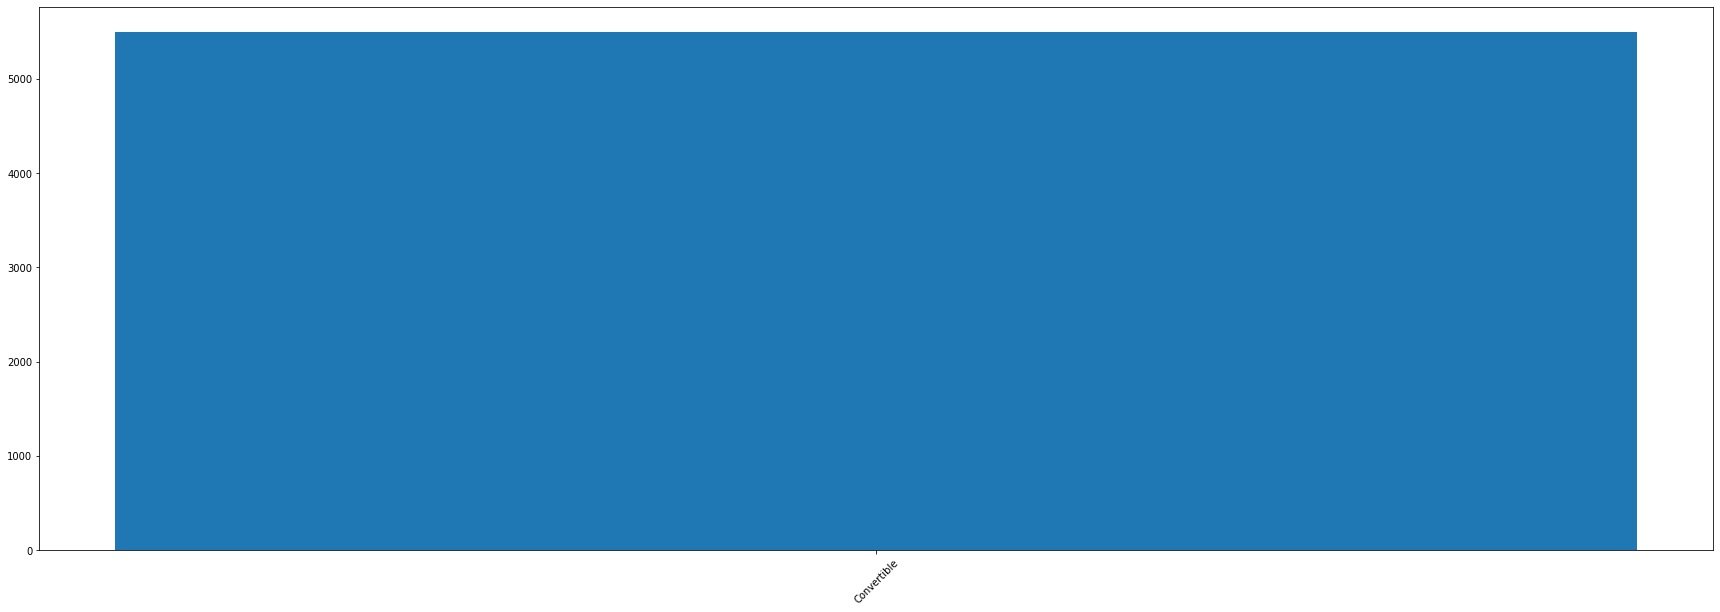

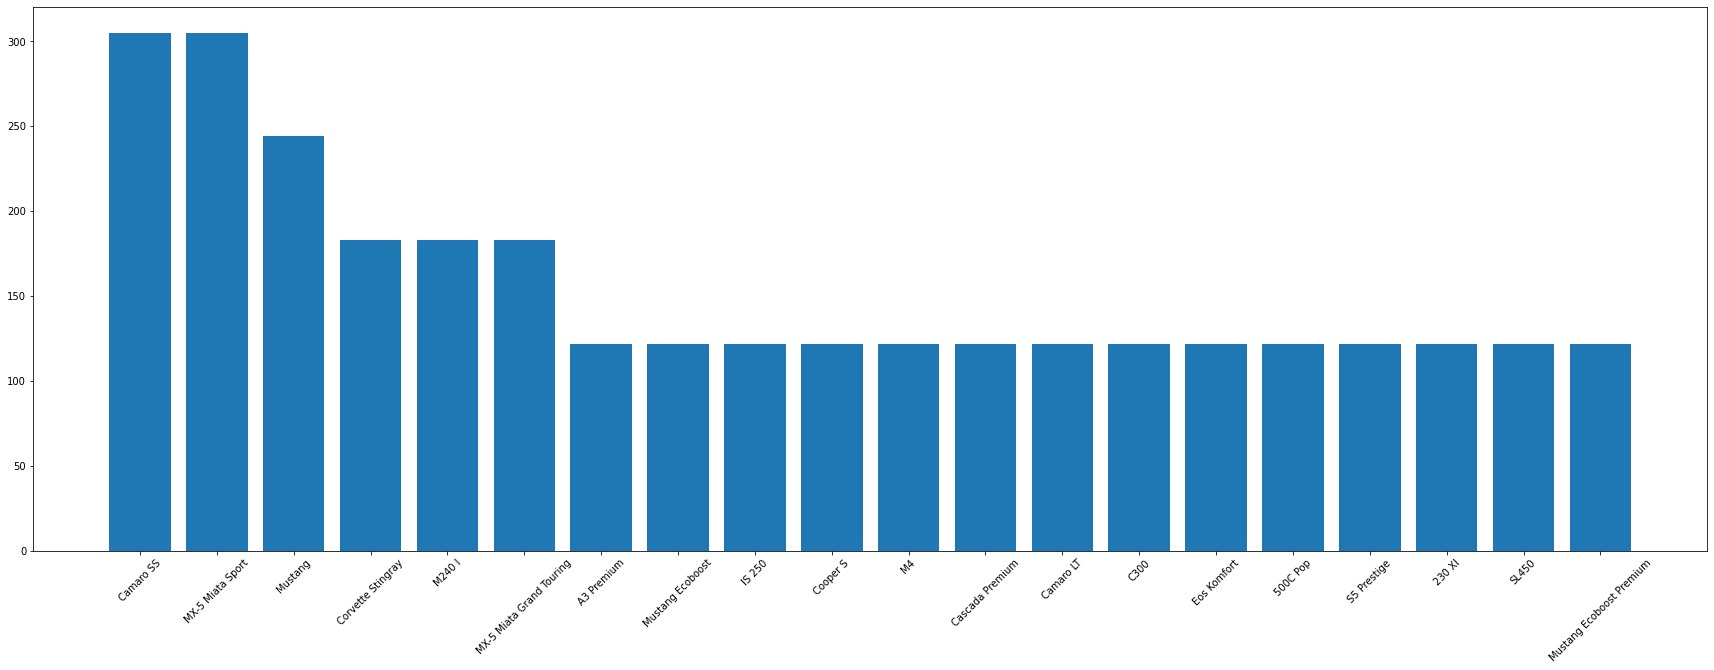

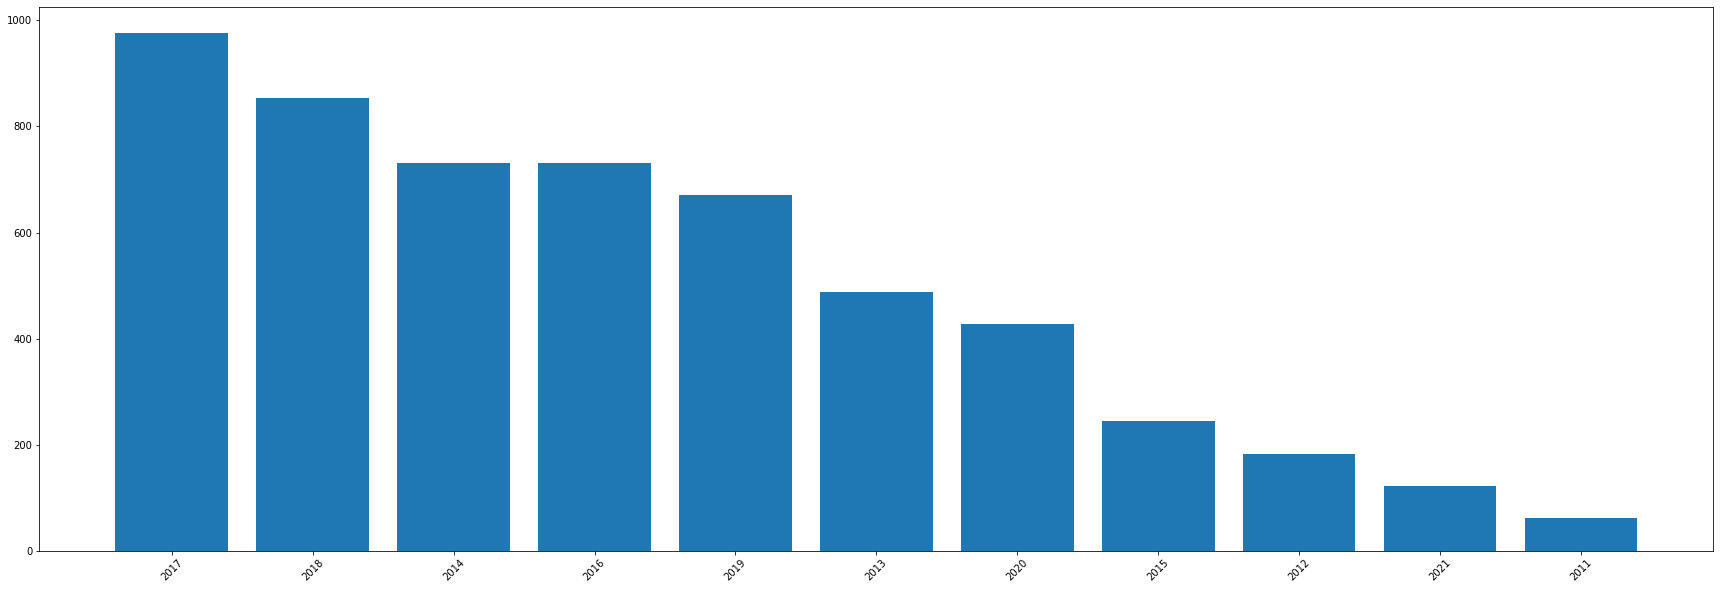

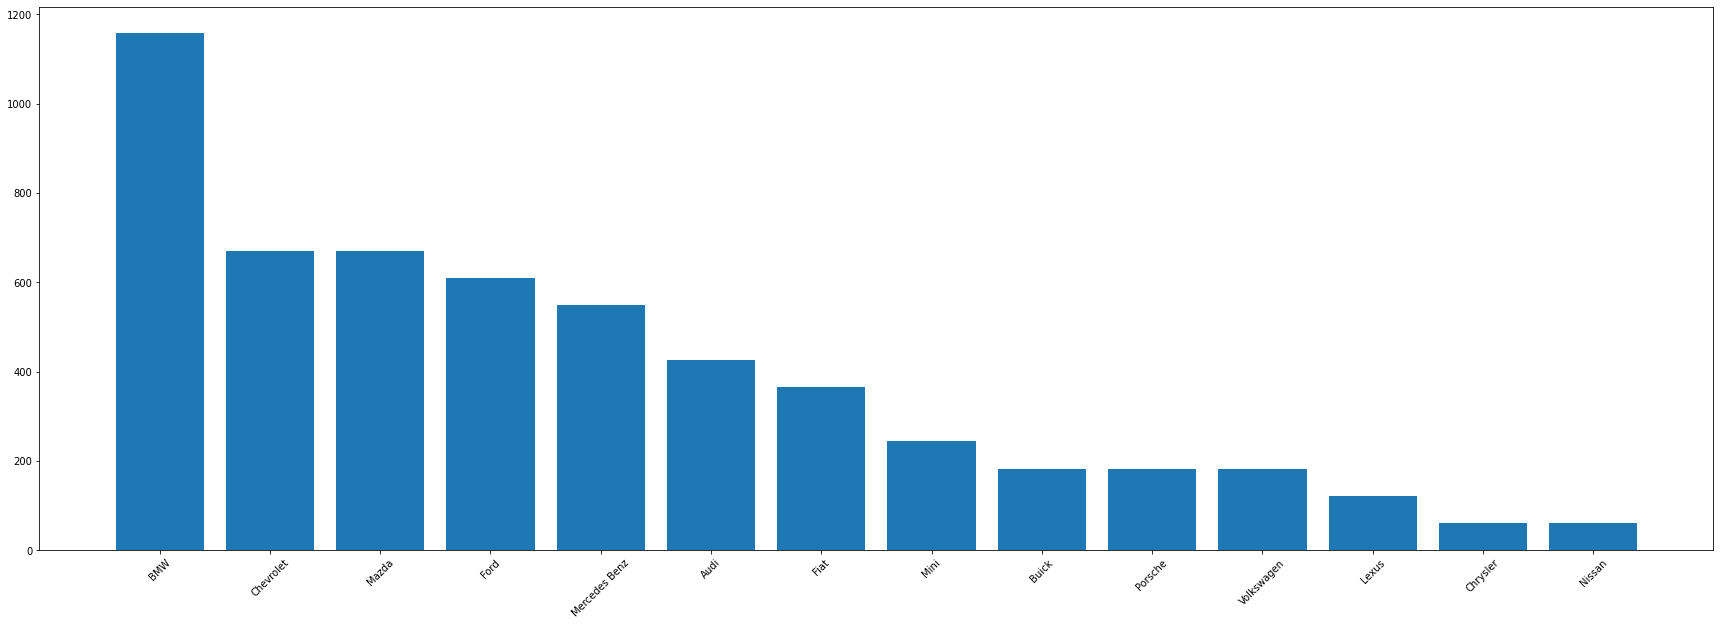

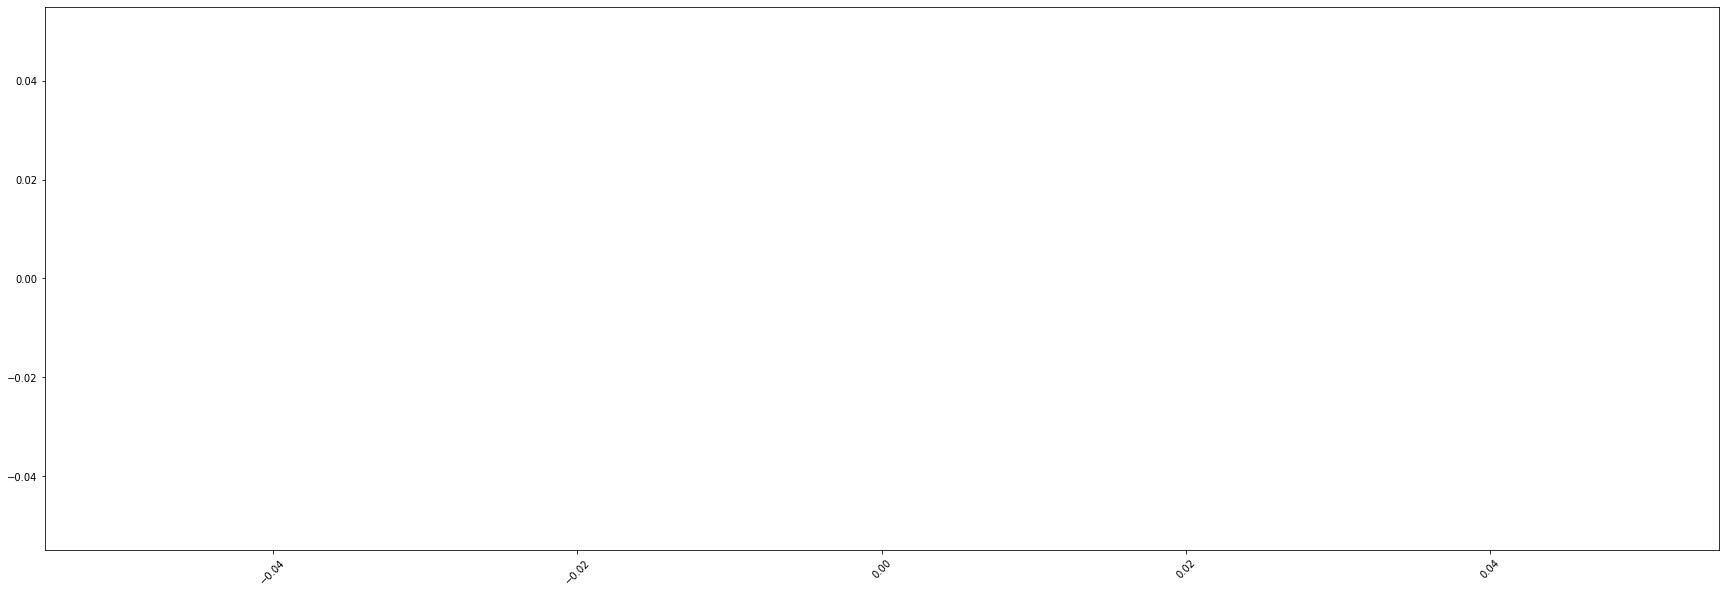

In [ ]:
PLOT_LIMIT_SIZE = 20

dimensions = ["type", "model", "year", "make", "color"]
for dimension in dimensions:
  grouped_df = crawler.vehicle_df.groupby(dimension).size().reset_index(name='count').sort_values(['count'], ascending=False).reset_index(drop=True)
  grouped_csv_data_output_filename = os.path.join(CSV_DIR, f'grouped-by-{dimension}')
  output_csv_filename = grouped_csv_data_output_filename + ".csv"

  grouped_df.to_csv(output_csv_filename)
  
  fig = plt.figure(figsize = (30, 10))

  x_data = grouped_df[dimension]
  y_data = grouped_df["count"]

  if dimension == "model":
    x_data = x_data[: PLOT_LIMIT_SIZE]
    y_data = y_data[: PLOT_LIMIT_SIZE]

  plt.bar(x_data, y_data)
  plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
  grouped_plots_data_output_filename = os.path.join(PLOTS_DIR, f'grouped-by-{dimension}')
  output_png_filename = grouped_plots_data_output_filename + ".png"
  fig.savefig(output_png_filename)

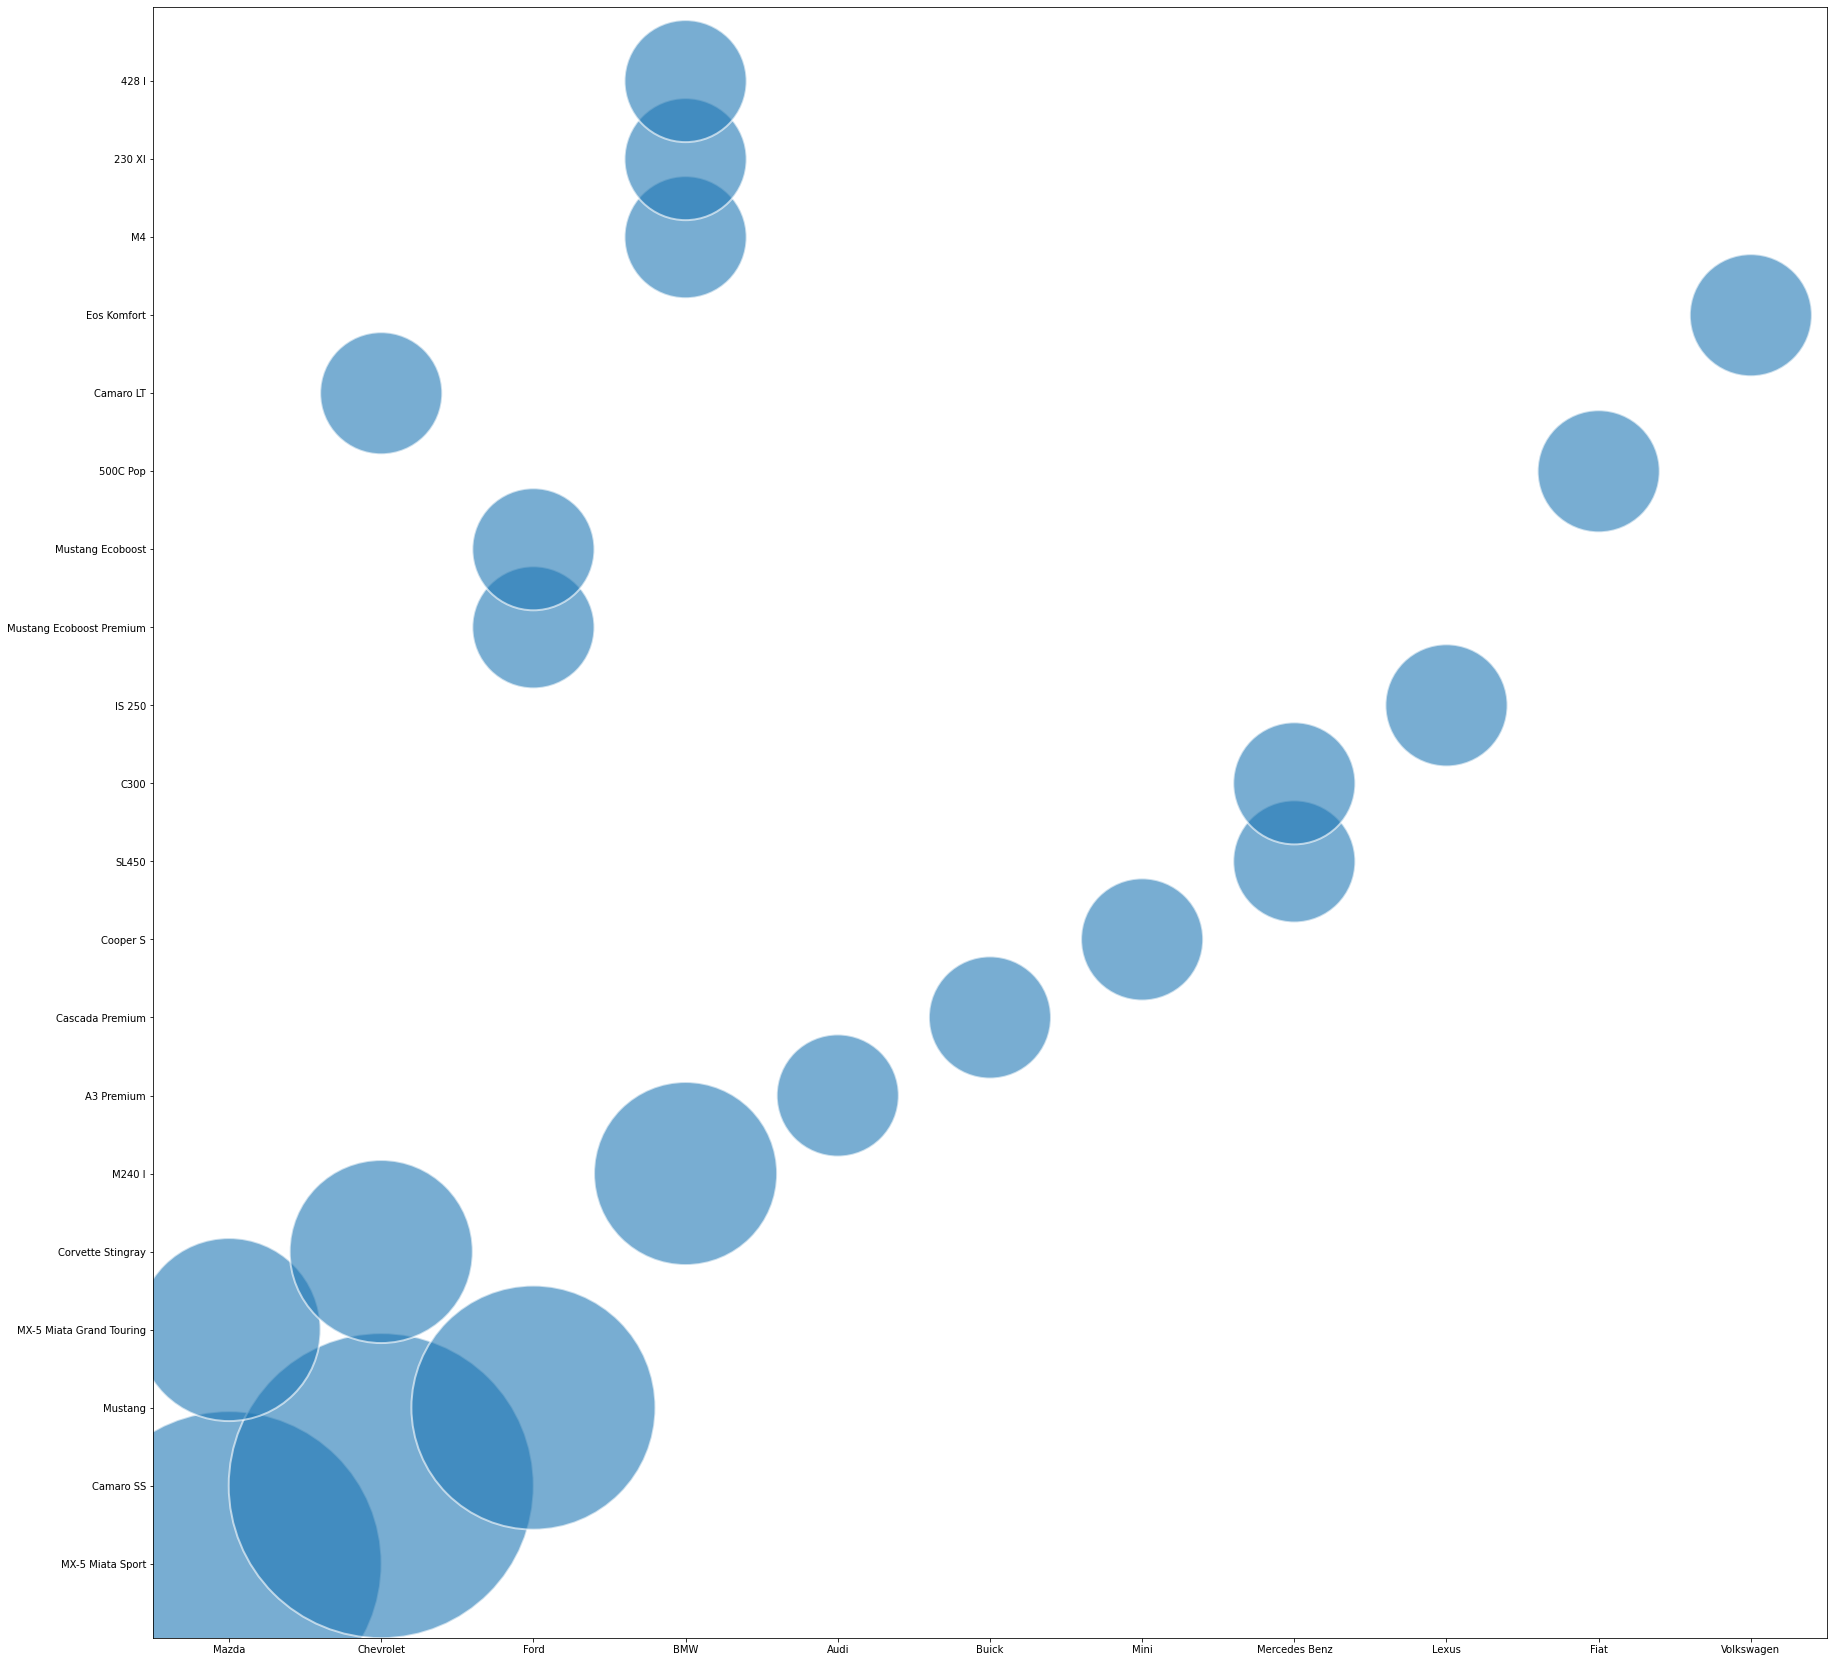

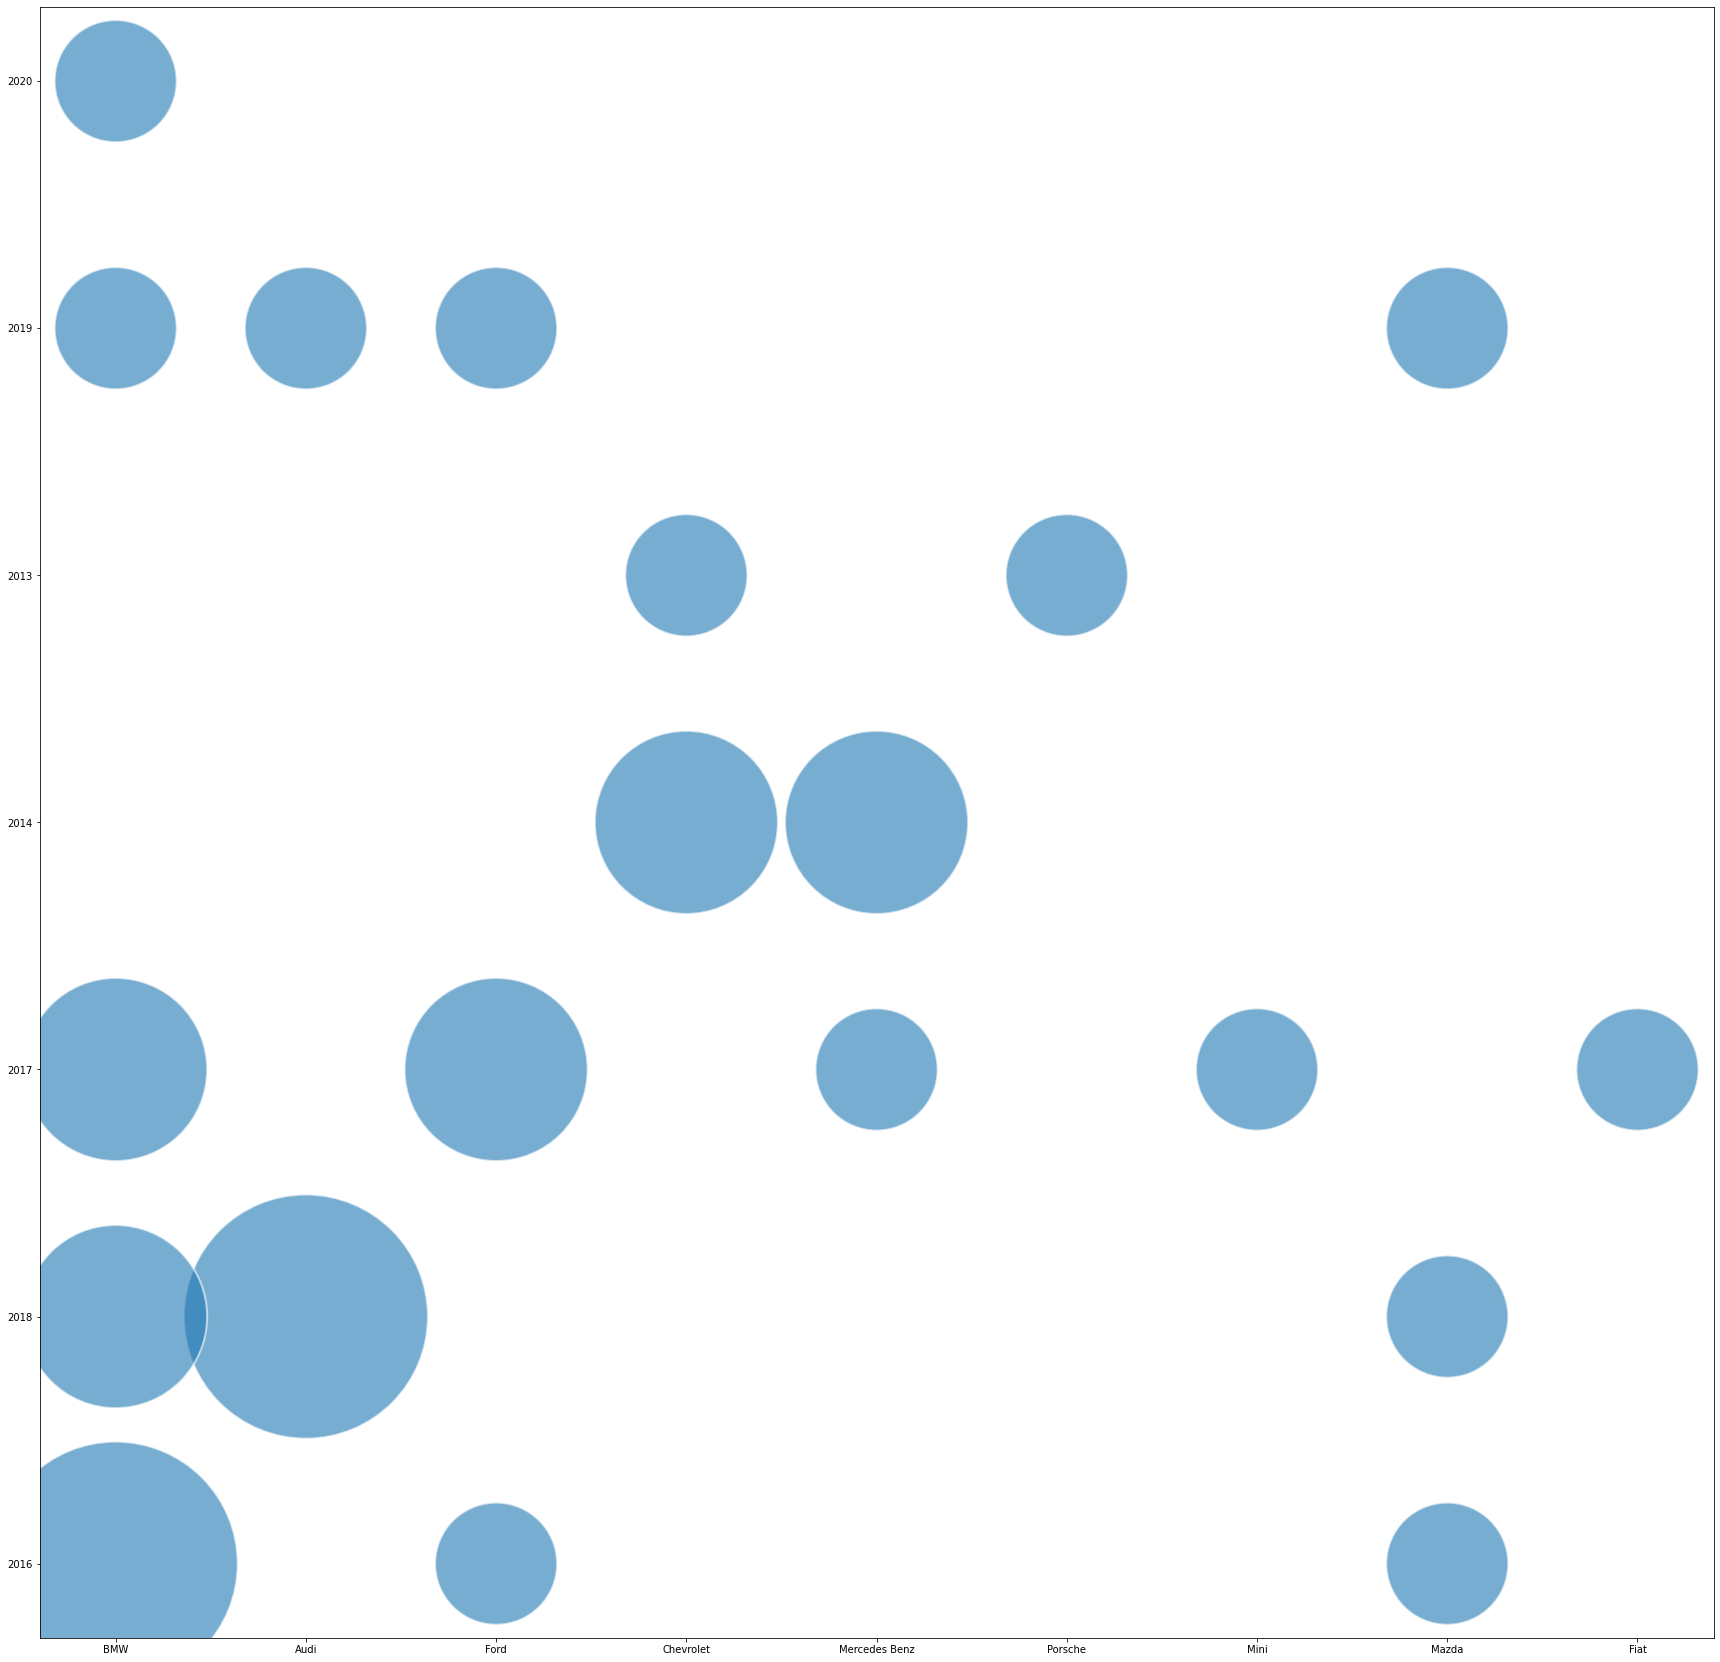

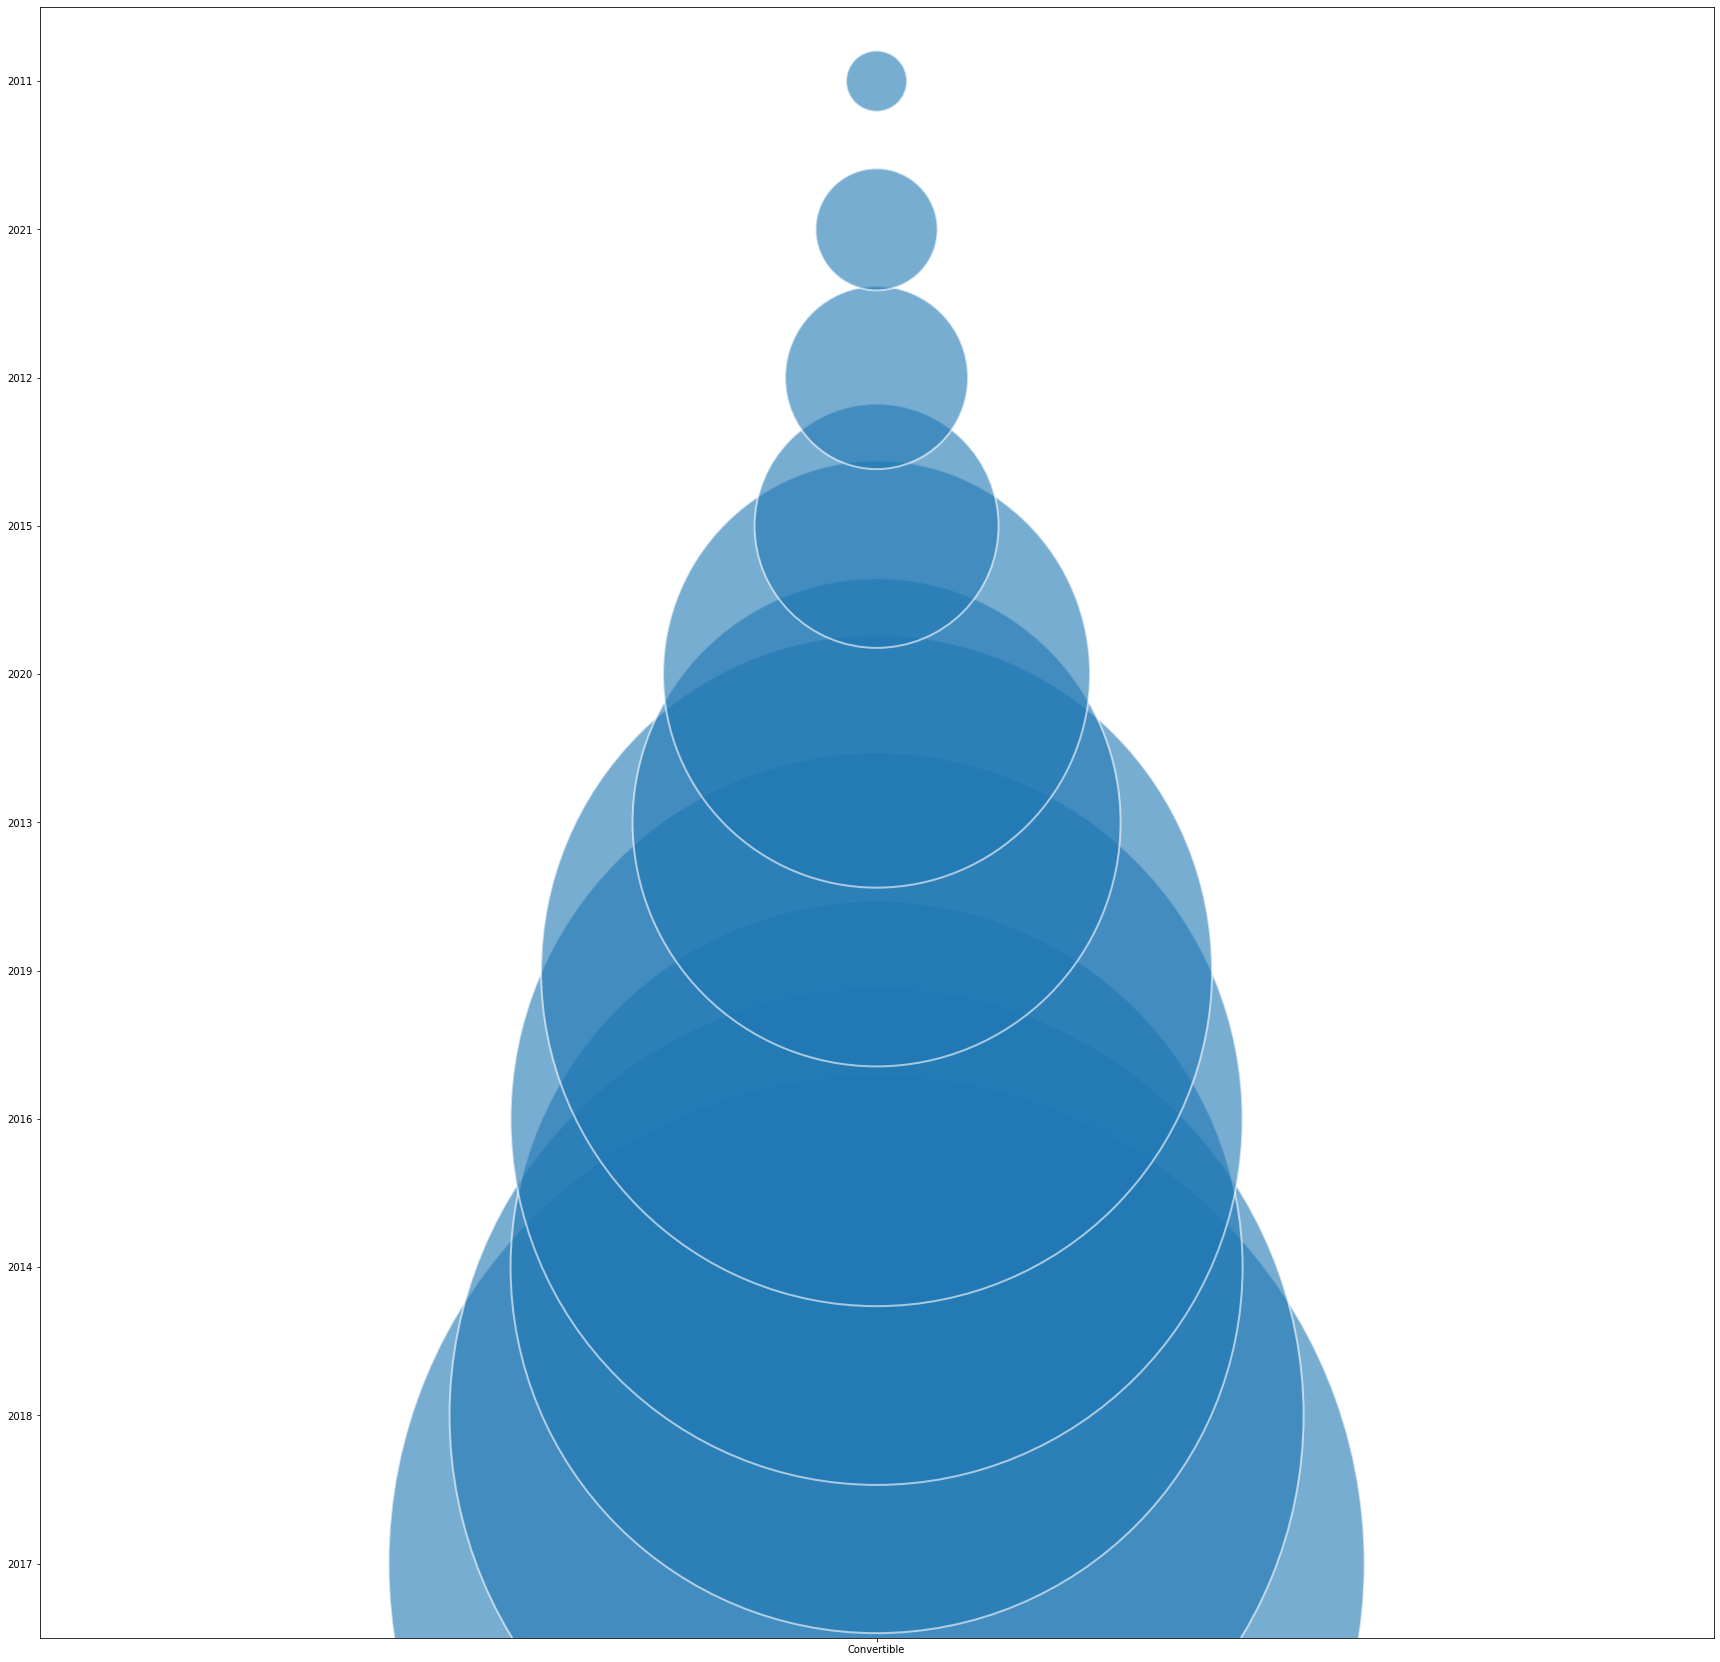

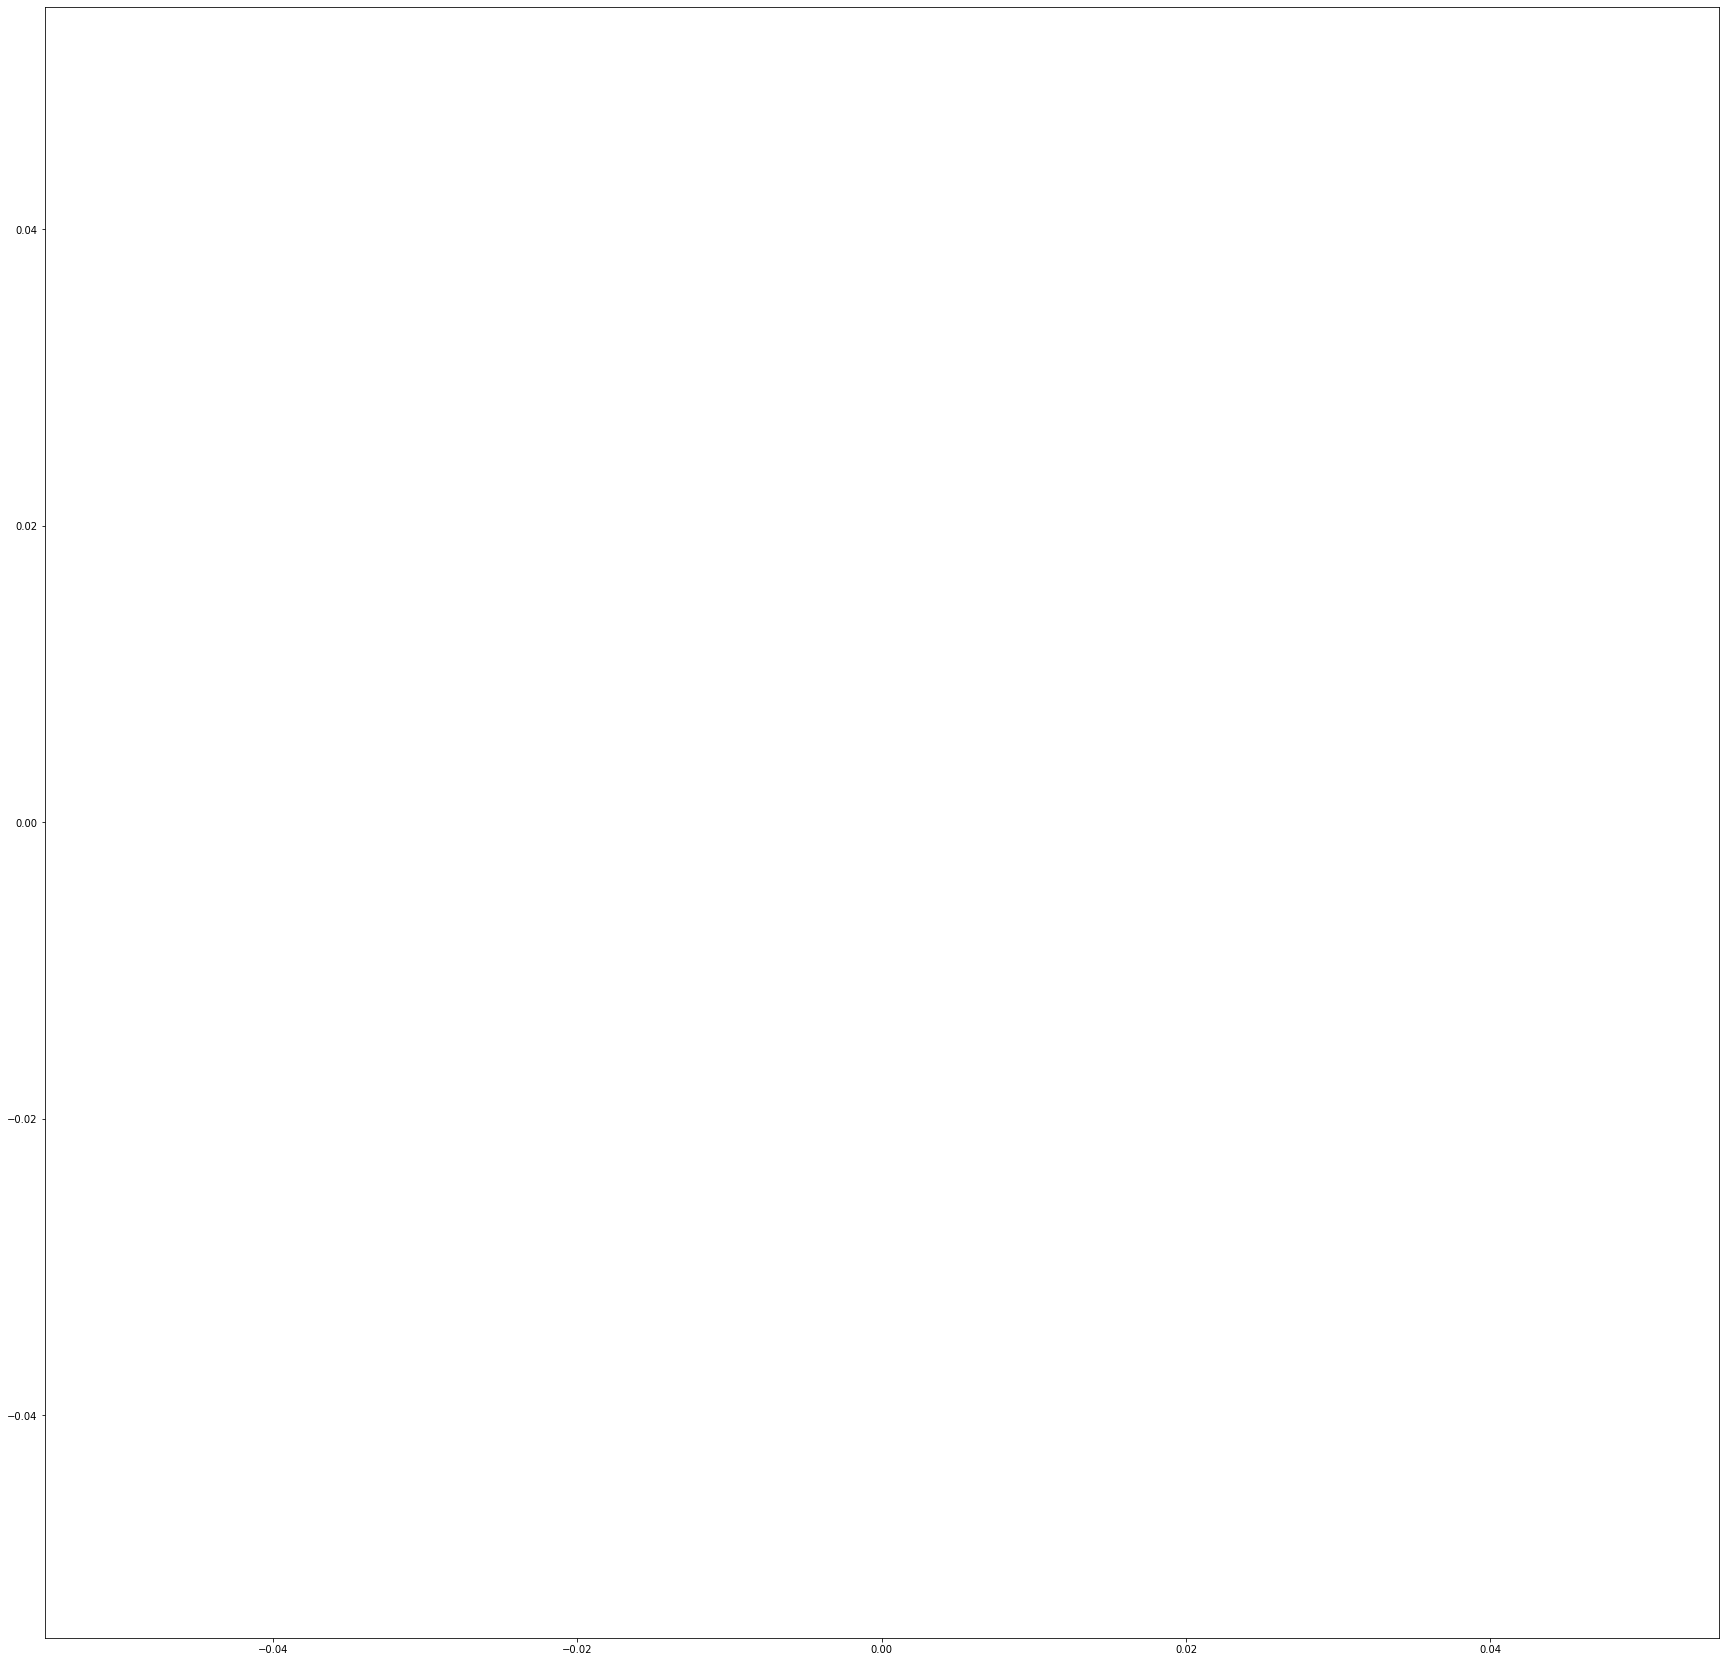

In [ ]:
MAKE_PLOT_LIMIT_SIZE = 20
pairwise_dimensions = [
    ["make", "model"],
    ["make", "year"],
    ["type", "year"],
    ["make", "color"]
]

for pairwise_dimension in pairwise_dimensions:

  grouped_df = crawler.vehicle_df.groupby(pairwise_dimension).size().reset_index(name='count').sort_values(['count'], ascending=False).reset_index(drop=True)
  grouped_csv_data_output_filename = os.path.join(CSV_DIR, f'grouped-by-{"-".join(pairwise_dimension)}')
  output_csv_filename = grouped_csv_data_output_filename + ".csv"

  grouped_df.to_csv(output_csv_filename)
  if "make" in pairwise_dimension:
      x_data = grouped_df[pairwise_dimension[0]][: MAKE_PLOT_LIMIT_SIZE]
      y_data = grouped_df[pairwise_dimension[1]][: MAKE_PLOT_LIMIT_SIZE]
      s_data = grouped_df["count"][: MAKE_PLOT_LIMIT_SIZE] ** 2
    
  else:
    x_data = grouped_df[pairwise_dimension[0]]
    y_data = grouped_df[pairwise_dimension[1]]
    s_data = grouped_df["count"] ** 2
    

  fig = plt.figure(figsize = (30, 30))
  plt.scatter(
    x=x_data, 
    y=y_data, 
    s=s_data,
    cmap="Accent", 
    alpha=0.6, 
    edgecolors="white", 
    linewidth=2
  );

  grouped_plots_data_output_filename = os.path.join(PLOTS_DIR, f'grouped-by-{"-".join(pairwise_dimension)}')
  output_png_filename = grouped_plots_data_output_filename + ".png"
  fig.savefig(output_png_filename)

# 3 Building a simple, single classification model for `original_tool_images.zip`

Here, we will built a simple model to classify a subset of original_tool_images.zip. Then we will expand to multiple labels. Finally, we will tackle the larger-scale datasets problem.

## 3.1 Single classification (Vehicle Type)

We will try with the vehicle type classifier first. Our architecture looks like:


[<img src="https://i.redd.it/cvjvsdlq4yx91.png" width="550"/>]

In [ ]:
class_name = "type"  # Make sure to change this to whatever name you used for make in your `original_tool_images` crawler
class_idx = 0         # Make sure to change this to whetever index `type` is in your Crawler's tuple!
path_idx = 5          # Change this to whichever index in tuple has path
crawler_args = {
    "log_level": "info",
    "seed": 21312411,
    "file_name" : "/content/convertible_images.zip",
    "train_split_frac": 0.8,
    "test_split_frac": 0.1,
    "validation_split_frac": 0.1
    # add any other kwargs here...
}

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from ednaml.core import EdnaML
from ednaml.generators import ClassificationGenerator

eml = EdnaML(config = "./GLAMOR/profiles/CarZam/base_config_with_backup.yml", config_inject=[
    ("SAVE.MODEL_QUALIFIER", class_name)
])

eml.cfg.EXECUTION.DATAREADER.CRAWLER_ARGS = crawler_args
eml.cfg.EXECUTION.DATAREADER.DATASET_ARGS["pathidx"] = path_idx
eml.cfg.EXECUTION.DATAREADER.DATASET_ARGS["annotationidx"] = class_idx
eml.cfg.EXECUTION.DATAREADER.DATASET_ARGS["classificationclass"] = class_name
eml.cfg.TRAIN_TRANSFORMATION.BATCH_SIZE = 256

eml.addGeneratorClass(ClassificationGenerator)
eml.addCrawlerClass(CarZamCrawler)

Injected key-value pair:  SAVE.MODEL_QUALIFIER, type


In [ ]:
eml.apply()

23:36:51 ****************************************
23:36:51 
23:36:51 
23:36:51 Using the following configuration:
23:36:51 DEPLOYMENT:
  DATAREADER:
    CRAWLER_ARGS: {}
    DATAREADER: DataReader
    DATASET_ARGS: {}
    GENERATOR: null
    GENERATOR_ARGS: {}
  DEPLOY: BaseDeploy
  DEPLOYMENT_ARGS: {}
  EPOCHS: 1
  OUTPUT_ARGS: {}
  PLUGIN:
    HOOKS: always
    RESET: false
EXECUTION:
  DATAREADER:
    CRAWLER_ARGS:
      file_name: /content/convertible_images.zip
      log_level: info
      seed: 21312411
      test_split_frac: 0.1
      train_split_frac: 0.8
      validation_split_frac: 0.1
    DATAREADER: DataReader
    DATASET_ARGS:
      annotationidx: 0
      classificationclass: type
      pathidx: 5
    GENERATOR: null
    GENERATOR_ARGS: {}
  EPOCHS: 10
  FP16: false
  MODEL_SERVING: Unused
  OPTIMIZER_BUILDER: ClassificationOptimizer
  PLUGIN:
    HOOKS: always
    RESET: false
  SKIPEVAL: false
  TEST_FREQUENCY: 1
  TRAINER: ClassificationTrainer
  TRAINER_ARGS:
    accumu

KeyboardInterrupt: ignored

In [ ]:
eml.train()

In [ ]:
resp = eml.eval()

## 3.2 Single classification (Vehicle Color)

Next, let's do vehicle color. Architecture remains the same, but we now focus on color features.

In [ ]:
class_name = "year"   # Make sure to change this to whatever name you used for make in your `original_tool_images` crawler
class_idx = 2         # Make sure to change this to whetever index `color` is in your Crawler's tuple!
path_idx = 5          # Change this to whichever index in tuple has path
crawler_args = {
    
    "log_level": "info",
    "seed": 21312411,
    "file_name" : "/content/convertible_images.zip",
    "train_split_frac": 0.8,
    "test_split_frac": 0.1,
    "validation_split_frac": 0.1
    # add any other kwargs here...
}

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from ednaml.core import EdnaML
from ednaml.generators import ClassificationGenerator

eml = EdnaML(config = "./GLAMOR/profiles/CarZam/base_config_with_backup.yml", config_inject=[
    ("SAVE.MODEL_QUALIFIER", class_name)
])

eml.cfg.EXECUTION.DATAREADER.CRAWLER_ARGS = crawler_args
eml.cfg.EXECUTION.DATAREADER.DATASET_ARGS["pathidx"] = path_idx
eml.cfg.EXECUTION.DATAREADER.DATASET_ARGS["annotationidx"] = class_idx
eml.cfg.EXECUTION.DATAREADER.DATASET_ARGS["classificationclass"] = class_name

eml.addGeneratorClass(ClassificationGenerator)
eml.addCrawlerClass(CarZamCrawler)

Injected key-value pair:  SAVE.MODEL_QUALIFIER, year
Log file exists at origtoolimgs-v1-singleclass-year/origtoolimgs-v1-singleclass-year-logger.log. Will attempt to append there.


In [ ]:
eml.apply()

02:09:51 ****************************************
02:09:51 
02:09:51 
02:09:51 Using the following configuration:
02:09:51 DEPLOYMENT:
  DATAREADER:
    CRAWLER_ARGS: {}
    DATAREADER: DataReader
    DATASET_ARGS: {}
    GENERATOR: null
    GENERATOR_ARGS: {}
  DEPLOY: BaseDeploy
  DEPLOYMENT_ARGS: {}
  EPOCHS: 1
  OUTPUT_ARGS: {}
  PLUGIN:
    HOOKS: always
    RESET: false
EXECUTION:
  DATAREADER:
    CRAWLER_ARGS:
      file_name: /content/convertible_images.zip
      log_level: info
      seed: 21312411
      test_split_frac: 0.1
      train_split_frac: 0.8
      validation_split_frac: 0.1
    DATAREADER: DataReader
    DATASET_ARGS:
      annotationidx: 2
      classificationclass: year
      pathidx: 5
    GENERATOR: null
    GENERATOR_ARGS: {}
  EPOCHS: 10
  FP16: false
  MODEL_SERVING: Unused
  OPTIMIZER_BUILDER: ClassificationOptimizer
  PLUGIN:
    HOOKS: always
    RESET: false
  SKIPEVAL: false
  TEST_FREQUENCY: 1
  TRAINER: ClassificationTrainer
  TRAINER_ARGS:
    accumu

In [ ]:
eml.train()

02:09:56 Starting training
02:09:56 Logging to:	origtoolimgs-v1-singleclass-year-logger.log
02:09:56 Models will be saved to local directory:	origtoolimgs-v1-singleclass-year
02:09:56 Logs will be backed up to drive directory:	checkpoint/origtoolimgs-v1-singleclass-year
02:09:56 Models will be backed up to drive directory:	checkpoint/origtoolimgs-v1-singleclass-year
02:09:56 Models will be saved with base name:	origtoolimgs-v1_epoch[].pth
02:09:56 Optimizers will be saved with base name:	origtoolimgs-v1_epoch[]_optimizer.pth
02:09:56 Schedulers will be saved with base name:	origtoolimgs-v1_epoch[]_scheduler.pth
02:09:56 Performing initial evaluation...
02:10:24 Obtained features, validation in progress
02:10:24 Accuracy: 14.026%
02:10:24 Micro F-score: 0.140
02:10:24 Weighted F-score: 0.070
02:10:24 Starting training from 0
02:10:28 Parameter Group `opt-1`: Starting epoch 0 with 130 steps and learning rate 1.00000E-03
02:13:06 Epoch0.99	Total Avg Loss: 1.550 Softmax: 0.510
02:14:05 ***

In [ ]:
resp = eml.eval()

03:33:17 Obtained features, validation in progress
03:33:17 Accuracy: 97.450%
03:33:17 Micro F-score: 0.974
03:33:17 Weighted F-score: 0.975


## 3.3 Single classification (Vehicle Make)

And finally, a make classifier

In [ ]:
class_name = "make"   # Make sure to change this to whatever name you used for make in your `original_tool_images` crawler
class_idx = 3         # Make sure to change this to whetever index `make` is in your Crawler's tuple!
path_idx = 5          # Change this to whichever index in tuple has path
crawler_args = {
    "log_level": "info",
    "seed": 21312411,
    "file_name" : "convertible_images.zip",
    "train_split_frac": 0.8,
    "test_split_frac": 0.1,
    "validation_split_frac": 0.1
}

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from ednaml.core import EdnaML
from ednaml.generators import ClassificationGenerator

eml = EdnaML(config = "./GLAMOR/profiles/CarZam/base_config_with_backup.yml", config_inject=[
    ("SAVE.MODEL_QUALIFIER", class_name)
])

eml.cfg.EXECUTION.DATAREADER.CRAWLER_ARGS = crawler_args
eml.cfg.EXECUTION.DATAREADER.DATASET_ARGS["pathidx"] = path_idx
eml.cfg.EXECUTION.DATAREADER.DATASET_ARGS["annotationidx"] = class_idx
eml.cfg.EXECUTION.DATAREADER.DATASET_ARGS["classificationclass"] = class_name

eml.addGeneratorClass(ClassificationGenerator)
eml.addCrawlerClass(CarZamCrawler)

Injected key-value pair:  SAVE.MODEL_QUALIFIER, make


In [ ]:
eml.apply()

01:17:29 ****************************************
01:17:29 
01:17:29 
01:17:29 Using the following configuration:
01:17:29 DEPLOYMENT:
  DATAREADER:
    CRAWLER_ARGS: {}
    DATAREADER: DataReader
    DATASET_ARGS: {}
    GENERATOR: null
    GENERATOR_ARGS: {}
  DEPLOY: BaseDeploy
  DEPLOYMENT_ARGS: {}
  EPOCHS: 1
  OUTPUT_ARGS: {}
  PLUGIN:
    HOOKS: always
    RESET: false
EXECUTION:
  DATAREADER:
    CRAWLER_ARGS:
      file_name: convertible_images.zip
      log_level: info
      seed: 21312411
      test_split_frac: 0.1
      train_split_frac: 0.8
      validation_split_frac: 0.1
    DATAREADER: DataReader
    DATASET_ARGS:
      annotationidx: 3
      classificationclass: make
      pathidx: 5
    GENERATOR: null
    GENERATOR_ARGS: {}
  EPOCHS: 10
  FP16: false
  MODEL_SERVING: Unused
  OPTIMIZER_BUILDER: ClassificationOptimizer
  PLUGIN:
    HOOKS: always
    RESET: false
  SKIPEVAL: false
  TEST_FREQUENCY: 1
  TRAINER: ClassificationTrainer
  TRAINER_ARGS:
    accumulation_st

46827520/46827520 bytes [████████████████████████████████████████████████████████████████████████████████████████████████████]
Download of resnet18-5c106cde.pth to https://download.pytorch.org/models/resnet18-5c106cde.pth completed


01:17:30 No previous stop detected. Will start from epoch 0
01:17:30 Loaded BaseStorage from ednaml.storage to build Storage
01:17:30 Reading data with DataReader DataReader
01:17:30 Default CRAWLER is <class 'ednaml.crawlers.Crawler'>
01:17:30 Default DATASET is <class 'torch.utils.data.dataset.Dataset'>
01:17:30 Default GENERATOR is <class 'ednaml.generators.ImageGenerator.ImageGenerator'>
01:17:30 Updating GENERATOR to queued class ClassificationGenerator
01:17:30 Updating CRAWLER to CarZamCrawler
01:17:30 Generated training data generator with 4392 training data points
01:17:30 Running classification model with classes: {'make': {'classes': 14}}
01:17:30 Generated test data/query generator
01:17:30 Loaded classification_model_builder from ednaml.models to build model
01:17:30 Finished instantiating model with ClassificationResnet architecture
01:17:30 Adding plugins after constructing model
01:17:30 No saved model weights provided.
01:17:34 Model Summary retured the following error

In [ ]:
eml.train()

01:17:38 Starting training
01:17:38 Logging to:	origtoolimgs-v1-singleclass-make-logger.log
01:17:38 Models will be saved to local directory:	origtoolimgs-v1-singleclass-make
01:17:38 Logs will be backed up to drive directory:	checkpoint/origtoolimgs-v1-singleclass-make
01:17:38 Models will be backed up to drive directory:	checkpoint/origtoolimgs-v1-singleclass-make
01:17:38 Models will be saved with base name:	origtoolimgs-v1_epoch[].pth
01:17:38 Optimizers will be saved with base name:	origtoolimgs-v1_epoch[]_optimizer.pth
01:17:38 Schedulers will be saved with base name:	origtoolimgs-v1_epoch[]_scheduler.pth
01:17:38 Performing initial evaluation...
01:18:08 Obtained features, validation in progress
01:18:08 Accuracy: 4.372%
01:18:08 Micro F-score: 0.044
01:18:08 Weighted F-score: 0.005
01:18:08 Starting training from 0
01:18:13 Parameter Group `opt-1`: Starting epoch 0 with 130 steps and learning rate 1.00000E-03
01:20:49 Epoch0.99	Total Avg Loss: 1.177 Softmax: 0.702
01:21:49 ****

In [ ]:
resp = eml.eval()

02:05:10 Obtained features, validation in progress
02:05:10 Accuracy: 96.539%
02:05:10 Micro F-score: 0.965
02:05:10 Weighted F-score: 0.966


# 4. Multiclass classifiers

Multiclass classifiers try to classify multiple things at once, using the same features. Sometimes it works, if the features are colocated or have some overlap. Othertimes, it doesn't work very well. We can examine this in case of our small dataset first.

## 4.1 Multi-class classification (year-type)

Now we will try a model that performs vehicle type AND vehicle color classification together. The config is already prepared for this in `profiles/color_type.yml`.

Our architecture looks like:

[<img src="https://i.redd.it/7ndvmdlq4yx91.png" width="550"/>]

In [11]:
DATASET = 'Convertible'

In [12]:
path_idx = 5          # Change this to whichever index in tuple has path
crawler_args = {
    "file_name" : f"/content/{DATASET.lower()}_images.zip",
    "log_level": "info",
    "seed": 21312411,
    "train_split_frac": 0.8,
    "test_split_frac": 0.1,
    "validation_split_frac": 0.1
}

In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
from ednaml.core import EdnaML
from ednaml.generators import ClassificationGenerator

eml = EdnaML(config = ["./GLAMOR/profiles/CarZam/base_config_with_backup.yml","./GLAMOR/profiles/CarZam/color_type.yml"])

eml.cfg.SAVE.MODEL_CORE_NAME = f'{DATASET}DatasetImgs'
eml.cfg.SAVE.MODEL_QUALIFIER = f'year-type'

eml.cfg.EXECUTION.DATAREADER.CRAWLER_ARGS = crawler_args
eml.cfg.EXECUTION.DATAREADER.DATASET_ARGS["pathidx"] = path_idx
# We have already set these in config
eml.cfg.EXECUTION.DATAREADER.DATASET_ARGS["annotationidx"] = [2, 0]
eml.cfg.EXECUTION.DATAREADER.DATASET_ARGS["classificationclass"] = ["year", "type"]

eml.cfg.MODEL.MODEL_KWARGS["outputs"] = [
    {"name": "type", "label": "type"},
    {"name": "out2", "label": "year"},

]
eml.cfg.LOSS[0].LABEL = "year"
eml.cfg.LOSS[0].NAME = "yearloss"

eml.cfg.LOSS[1].LABEL = "type"
eml.cfg.LOSS[1].NAME = "typeloss"
# We have already set these in config
#eml.cfg.EXECUTION.DATAREADER.DATASET_ARGS["annotationidx"] = class_idx
#eml.cfg.EXECUTION.DATAREADER.DATASET_ARGS["classificationclass"] = class_name

#eml.addGeneratorClass(MultiClassificationGenerator)
eml.addCrawlerClass(CarZamCrawler)

In [15]:
eml.apply()

23:09:43 ****************************************
23:09:43 
23:09:43 
23:09:43 Using the following configuration:
23:09:43 DEPLOYMENT:
  DATAREADER:
    CRAWLER_ARGS: {}
    DATAREADER: DataReader
    DATASET_ARGS: {}
    GENERATOR: null
    GENERATOR_ARGS: {}
  DEPLOY: BaseDeploy
  DEPLOYMENT_ARGS: {}
  EPOCHS: 1
  OUTPUT_ARGS: {}
  PLUGIN:
    HOOKS: always
    RESET: false
EXECUTION:
  DATAREADER:
    CRAWLER_ARGS:
      file_name: /content/convertible_images.zip
      log_level: info
      seed: 21312411
      test_split_frac: 0.1
      train_split_frac: 0.8
      validation_split_frac: 0.1
    DATAREADER: DataReader
    DATASET_ARGS:
      annotationidx:
      - 2
      - 0
      classificationclass:
      - year
      - type
      pathidx: 5
    GENERATOR: MultiClassificationGenerator
    GENERATOR_ARGS: {}
  EPOCHS: 10
  FP16: false
  MODEL_SERVING: Unused
  OPTIMIZER_BUILDER: ClassificationOptimizer
  PLUGIN:
    HOOKS: always
    RESET: false
  SKIPEVAL: false
  TEST_FREQUENCY

46827520/46827520 bytes [████████████████████████████████████████████████████████████████████████████████████████████████████]

23:09:45 No previous stop detected. Will start from epoch 0
23:09:45 Loaded BaseStorage from ednaml.storage to build Storage
23:09:45 Reading data with DataReader DataReader
23:09:45 Default CRAWLER is <class 'ednaml.crawlers.Crawler'>
23:09:45 Default DATASET is <class 'torch.utils.data.dataset.Dataset'>



Download of resnet18-5c106cde.pth to https://download.pytorch.org/models/resnet18-5c106cde.pth completed


23:09:45 Default GENERATOR is <class 'ednaml.generators.ImageGenerator.ImageGenerator'>
23:09:45 Updating GENERATOR using config specification to MultiClassificationGenerator
23:09:45 Updating CRAWLER to CarZamCrawler
23:09:45 Generated training data generator with 4392 training data points
23:09:45 Running classification model with classes: {'year': {'classes': 11}, 'type': {'classes': 1}}
23:09:45 Generated test data/query generator
23:09:45 Loaded multiclassification_model_builder from ednaml.models to build model
23:09:45 Finished instantiating model with MultiClassificationResnet architecture
23:09:45 Adding plugins after constructing model
23:09:45 No saved model weights provided.
23:09:49 Model Summary retured the following error:
23:09:49 Traceback (most recent call last):
  File "/content/GLAMOR/src/ednaml/core/EdnaML.py", line 888, in getModelSummary
    self.cfg.TRAIN_TRANSFORMATION.INPUT_SIZE,
AttributeError: 'TransformationConfig' object has no attribute 'INPUT_SIZE'

23:0

In [16]:
eml.train()

23:09:53 Starting training
23:09:53 Logging to:	origtoolimgs-v1-multiclass-color-vtype-logger.log
23:09:53 Models will be saved to local directory:	origtoolimgs-v1-multiclass-color-vtype
23:09:53 Models will be saved with base name:	origtoolimgs-v1_epoch[].pth
23:09:53 Optimizers will be saved with base name:	origtoolimgs-v1_epoch[]_optimizer.pth
23:09:53 Schedulers will be saved with base name:	origtoolimgs-v1_epoch[]_scheduler.pth
23:09:53 Performing initial evaluation...
23:10:50 Obtained features, validation in progress
23:10:50 Metrics	yearloss	typeloss
23:10:50 Accuracy	year: 0.088	type: 1.000
23:10:50 M F-Score	year: 0.088	type: 1.000
23:10:50 W F-Score	year: 0.045	type: 1.000
23:10:50 Starting training from 0
23:10:53 Parameter Group `opt-1`: Starting epoch 0 with 130 steps and learning rate 1.00000E-03
23:13:31 Epoch0.99	Total Avg Loss: 0.766 Softmax: 0.000
23:14:30 ********** Completed epoch 0 **********
23:14:30 Model evaluation triggered, but gradients still need accumulati

In [17]:
resp = eml.eval()

00:01:56 Obtained features, validation in progress
00:01:56 Metrics	yearloss	typeloss
00:01:56 Accuracy	year: 0.979	type: 1.000
00:01:56 M F-Score	year: 0.979	type: 1.000
00:01:56 W F-Score	year: 0.979	type: 1.000


## 4.2 Multi-class classification (year-type-make)

Now we will try a model that performs vehicle type vehicle color, and vehicle make classification together. The config is already prepared for this in `profiles/color_type_make.yml`

Our architecture now looks like:

[<img src="https://i.redd.it/8sbfqblq4yx91.png" width="550"/>]

In [22]:
path_idx = 5          # Change this to whichever index in tuple has path
crawler_args = {
    "file_name" : f"/content/{DATASET.lower()}_images.zip",
    "log_level": "info",
    "seed": 21312411,
    "train_split_frac": 0.8,
    "test_split_frac": 0.1,
    "validation_split_frac": 0.1
}

In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
from ednaml.core import EdnaML
from ednaml.generators import ClassificationGenerator

eml = EdnaML(config = ["./GLAMOR/profiles/CarZam/base_config_with_backup.yml","./GLAMOR/profiles/CarZam/color_type_make.yml"])

eml.cfg.SAVE.MODEL_CORE_NAME = f'{DATASET}DatasetImgs'
eml.cfg.SAVE.MODEL_QUALIFIER = f'year-type-make'
eml.cfg.EXECUTION.DATAREADER.CRAWLER_ARGS = crawler_args
eml.cfg.EXECUTION.DATAREADER.DATASET_ARGS["pathidx"] = path_idx
eml.cfg.EXECUTION.DATAREADER.DATASET_ARGS["annotationidx"] = [2, 0, 3]
eml.cfg.EXECUTION.DATAREADER.DATASET_ARGS["classificationclass"] = ["year", "type", "make"]

eml.cfg.MODEL.MODEL_KWARGS["outputs"] = [
    {"name": "type", "label": "type"},
    {"name": "out2", "label": "year"},
    {"name": "makeout", "label": "make"},
]
eml.cfg.LOSS[0].LABEL = "year"
eml.cfg.LOSS[0].NAME = "yearloss"

eml.cfg.LOSS[1].LABEL = "type"
eml.cfg.LOSS[1].NAME = "typeloss"

eml.cfg.LOSS[2].LABEL = "make"
eml.cfg.LOSS[2].NAME = "makeloss"
eml.addCrawlerClass(CarZamCrawler)

Log file exists at origtoolimgs-v1-multiclass-color-vtype-make/origtoolimgs-v1-multiclass-color-vtype-make-logger.log. Will attempt to append there.


In [26]:
eml.apply()

00:06:57 ****************************************
00:06:57 
00:06:57 
00:06:57 Using the following configuration:
00:06:57 DEPLOYMENT:
  DATAREADER:
    CRAWLER_ARGS: {}
    DATAREADER: DataReader
    DATASET_ARGS: {}
    GENERATOR: null
    GENERATOR_ARGS: {}
  DEPLOY: BaseDeploy
  DEPLOYMENT_ARGS: {}
  EPOCHS: 1
  OUTPUT_ARGS: {}
  PLUGIN:
    HOOKS: always
    RESET: false
EXECUTION:
  DATAREADER:
    CRAWLER_ARGS:
      file_name: /content/convertible_images.zip
      log_level: info
      seed: 21312411
      test_split_frac: 0.1
      train_split_frac: 0.8
      validation_split_frac: 0.1
    DATAREADER: DataReader
    DATASET_ARGS:
      annotationidx:
      - 2
      - 0
      - 3
      classificationclass:
      - year
      - type
      - make
      pathidx: 5
    GENERATOR: MultiClassificationGenerator
    GENERATOR_ARGS: {}
  EPOCHS: 10
  FP16: false
  MODEL_SERVING: Unused
  OPTIMIZER_BUILDER: ClassificationOptimizer
  PLUGIN:
    HOOKS: always
    RESET: false
  SKIPEVAL:

In [27]:
eml.train()

00:07:02 Starting training
00:07:02 Logging to:	origtoolimgs-v1-multiclass-color-vtype-make-logger.log
00:07:02 Models will be saved to local directory:	origtoolimgs-v1-multiclass-color-vtype-make
00:07:02 Models will be saved with base name:	origtoolimgs-v1_epoch[].pth
00:07:02 Optimizers will be saved with base name:	origtoolimgs-v1_epoch[]_optimizer.pth
00:07:02 Schedulers will be saved with base name:	origtoolimgs-v1_epoch[]_scheduler.pth
00:07:02 Performing initial evaluation...
00:07:57 Obtained features, validation in progress
00:07:57 Metrics	yearloss	typeloss	makeloss
00:07:57 Accuracy	year: 0.064	type: 1.000	make: 0.065
00:07:57 M F-Score	year: 0.064	type: 1.000	make: 0.065
00:07:57 W F-Score	year: 0.056	type: 1.000	make: 0.009
00:07:57 Starting training from 0
00:08:01 Parameter Group `opt-1`: Starting epoch 0 with 130 steps and learning rate 1.00000E-03
00:10:40 Epoch0.99	Total Avg Loss: 1.010 Softmax: 0.000
00:11:41 ********** Completed epoch 0 **********
00:11:41 Model ev

In [28]:
resp = eml.eval()

01:04:39 Obtained features, validation in progress
01:04:39 Metrics	yearloss	typeloss	makeloss
01:04:39 Accuracy	year: 0.979	type: 1.000	make: 0.964
01:04:39 M F-Score	year: 0.979	type: 1.000	make: 0.964
01:04:39 W F-Score	year: 0.979	type: 1.000	make: 0.970


# 5. Multibranch classification

Now we will try a model that uses multiple branches, each branch for a specific label, for classification. Then we will fuse the branches to classify one more things. So total, three classifications from a single model.

## 5.1 Vehicle year and type, fused to classify vehicle make
Now we will try a model that performs vehicle type AND vehicle color classification together, using 2 different branches, and fuses the results together for make classification. The config is already prepared for this in `profiles/multibranch-ctm.yml`

Our architecture looks like:

[<img src="https://i.redd.it/q0urublq4yx91.png" width="550"/>]

Here, each branch yields its own prediction, and also sends features to the fusion branch (which is the make module in our case)

In [40]:
path_idx = 5          # Change this to whichever index in tuple has path
crawler_args = {
    "log_level": "info",
    "seed": 21312411,
    "file_name" : f"/content/{DATASET.lower()}_images.zip",
    "train_split_frac": 0.8,
    "test_split_frac": 0.1,
    "validation_split_frac": 0.1
}

In [41]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
from ednaml.core import EdnaML
from ednaml.generators import ClassificationGenerator

eml = EdnaML(config = ["./GLAMOR/profiles/CarZam/base_config_with_backup.yml","./GLAMOR/profiles/CarZam/multibranch-ctm.yml"])

eml.cfg.SAVE.MODEL_CORE_NAME = f'{DATASET}DatasetImgs'
eml.cfg.SAVE.MODEL_QUALIFIER = f'year-type-make'

eml.cfg.EXECUTION.DATAREADER.CRAWLER_ARGS = crawler_args
eml.cfg.EXECUTION.DATAREADER.DATASET_ARGS["pathidx"] = path_idx
eml.cfg.EXECUTION.DATAREADER.DATASET_ARGS["annotationidx"] = [2, 0, 3]
eml.cfg.EXECUTION.DATAREADER.DATASET_ARGS["classificationclass"] = ["year", "type", "make"]

eml.cfg.MODEL.MODEL_KWARGS = {
    "number_branches": 2,
    "branches": [
      {
          "name": "yearbranch",
          "number_outputs": 1,
          "outputs": [{"dimensions": None, "name": "year-fc", "label": "year"}]
       
      },
      {
          "name": "typebranch",
          "number_outputs": 1,
          "outputs": [{"dimensions": None, "name": "type-fc", "label": "type"}]
      }
    ],
    "fuse": True,
    "fuse_outputs": ["yearbranch", "typebranch"],
    "fuse_dimensions": None,
    "fuse_label": "make",
    "fuse_name": "fuse",
    "shared_block": 2,
    "soft_targets": True,
    "soft_target_branch": ["yearbranch", "typebranch"],
    "soft_target_output_source": "fuse"
}
eml.cfg.LOSS[0].LABEL = "year"
eml.cfg.LOSS[0].NAME = "year-fc"

eml.cfg.LOSS[1].LABEL = "type"
eml.cfg.LOSS[1].NAME = "type-fc"

eml.cfg.LOSS[2].LABEL = "make"
eml.cfg.LOSS[2].NAME = "fuse"

eml.cfg.LOSS[3].LABEL = "make"
eml.cfg.LOSS[3].NAME = "yearbranch"

eml.cfg.LOSS[4].LABEL = "make"
eml.cfg.LOSS[4].NAME = "typebranch"
eml.addCrawlerClass(CarZamCrawler)

Log file exists at origtoolimgs-v1-multibranch-color-vtype-make/origtoolimgs-v1-multibranch-color-vtype-make-logger.log. Will attempt to append there.


In [67]:
eml.apply()

01:49:13 ****************************************
01:49:13 
01:49:13 
01:49:13 Using the following configuration:
01:49:13 DEPLOYMENT:
  DATAREADER:
    CRAWLER_ARGS: {}
    DATAREADER: DataReader
    DATASET_ARGS: {}
    GENERATOR: null
    GENERATOR_ARGS: {}
  DEPLOY: BaseDeploy
  DEPLOYMENT_ARGS: {}
  EPOCHS: 1
  OUTPUT_ARGS: {}
  PLUGIN:
    HOOKS: always
    RESET: false
EXECUTION:
  DATAREADER:
    CRAWLER_ARGS:
      file_name: /content/convertible_images.zip
      log_level: info
      seed: 21312411
      test_split_frac: 0.1
      train_split_frac: 0.8
      validation_split_frac: 0.1
    DATAREADER: DataReader
    DATASET_ARGS:
      annotationidx:
      - 2
      - 0
      - 3
      classificationclass:
      - year
      - type
      - make
      pathidx: 5
    GENERATOR: MultiClassificationGenerator
    GENERATOR_ARGS: {}
  EPOCHS: 10
  FP16: false
  MODEL_SERVING: Unused
  OPTIMIZER_BUILDER: ClassificationOptimizer
  PLUGIN:
    HOOKS: always
    RESET: false
  SKIPEVAL:

In [68]:
eml.train()

01:49:17 Starting training
01:49:17 Logging to:	origtoolimgs-v1-multibranch-color-vtype-make-logger.log
01:49:17 Models will be saved to local directory:	origtoolimgs-v1-multibranch-color-vtype-make
01:49:17 Models will be saved with base name:	origtoolimgs-v1_epoch[].pth
01:49:17 Optimizers will be saved with base name:	origtoolimgs-v1_epoch[]_optimizer.pth
01:49:17 Schedulers will be saved with base name:	origtoolimgs-v1_epoch[]_scheduler.pth
01:49:17 Performing initial evaluation...
01:50:13 Obtained features, validation in progress
01:50:13 Metrics	year-fc	type-fc	fuse	yearbranch	typebranch
01:50:13 Accuracy	year-fc: 0.086	type-fc: 1.000	fuse: 0.046	yearbranch: 0.024	typebranch: 0.027
01:50:13 M F-Score	year-fc: 0.086	type-fc: 1.000	fuse: 0.046	yearbranch: 0.024	typebranch: 0.027
01:50:13 W F-Score	year-fc: 0.046	type-fc: 1.000	fuse: 0.042	yearbranch: 0.005	typebranch: 0.021
01:50:13 Starting training from 0
01:50:17 Parameter Group `opt-1`: Starting epoch 0 with 130 steps and lear

In [69]:
resp = eml.eval()

02:43:28 Obtained features, validation in progress
02:43:28 Metrics	year-fc	type-fc	fuse	yearbranch	typebranch
02:43:28 Accuracy	year-fc: 0.978	type-fc: 1.000	fuse: 0.968	yearbranch: 0.968	typebranch: 0.968
02:43:28 M F-Score	year-fc: 0.978	type-fc: 1.000	fuse: 0.968	yearbranch: 0.968	typebranch: 0.968
02:43:28 W F-Score	year-fc: 0.978	type-fc: 1.000	fuse: 0.968	yearbranch: 0.968	typebranch: 0.968


In [ ]:
%ls


bin/      dev/   lib32/  NGC-DL-CONTAINER-LICENSE  root/  sys/    usr/
boot/     etc/   lib64/  opt/                      run/   tmp/    var/
content/  home/  media/  proc/                     sbin/  tools/
datalab/  lib/   mnt/    python-apt/               srv/   Users/


In [ ]:
%ls

bin/      dev/   lib32/  NGC-DL-CONTAINER-LICENSE  root/  sys/    usr/
boot/     etc/   lib64/  opt/                      run/   tmp/    var/
content/  home/  media/  proc/                     sbin/  tools/
datalab/  lib/   mnt/    python-apt/               srv/   Users/


In [ ]:
%cp -avr /content /content/drive/MyDrive/

cp: cannot create directory '/content/drive/MyDrive/': No such file or directory


In [ ]:
%cp -r "/content/origtoolimgs-v1-singleclass-make" "/content/gdrive/MyDrive/Carzam"

In [ ]:
%cp -r "/content/origtoolimgs-v1-singleclass-year" "/content/gdrive/MyDrive/Carzam"

In [ ]:
%cd /drive


[Errno 2] No such file or directory: '/drive'
/


In [ ]:

from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [37]:
%ls

convertible_images.zip   origtoolimgs-v1-multiclass-color-vtype/
drive/                   origtoolimgs-v1-multiclass-color-vtype-make/
GLAMOR/                  resnet18-5c106cde.pth
original_tool_image.zip  sample_data/


In [38]:
%cp -r "/content/origtoolimgs-v1-multiclass-color-vtype" "/content/drive/MyDrive/Carzam"

In [39]:
%cp -r "/content/origtoolimgs-v1-multiclass-color-vtype-make" "/content/drive/MyDrive/Carzam"

In [70]:
%cp -r "/content/origtoolimgs-v1-multibranch-color-vtype-make" "/content/drive/MyDrive/Carzam"

# **Multibranch classification - combined dataset - make and year to get model**

In [ ]:
path_idx = 5          # Change this to whichever index in tuple has path
crawler_args = {
    "log_level": "info",
    "seed": 21312411,
    "file_name" : f"/content/{DATASET.lower()}_images.zip",
    "train_split_frac": 0.8,
    "test_split_frac": 0.1,
    "validation_split_frac": 0.1
}

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from ednaml.core import EdnaML
from ednaml.generators import ClassificationGenerator

eml = EdnaML(config = ["./GLAMOR/profiles/CarZam/base_config_with_backup.yml","./GLAMOR/profiles/CarZam/multibranch-ctm.yml"])

eml.cfg.SAVE.MODEL_CORE_NAME = f'{DATASET}DatasetImgs'
eml.cfg.SAVE.MODEL_QUALIFIER = f'year-type-make'

eml.cfg.EXECUTION.DATAREADER.CRAWLER_ARGS = crawler_args
eml.cfg.EXECUTION.DATAREADER.DATASET_ARGS["pathidx"] = path_idx
eml.cfg.EXECUTION.DATAREADER.DATASET_ARGS["annotationidx"] = [2, 0, 3]
eml.cfg.EXECUTION.DATAREADER.DATASET_ARGS["classificationclass"] = ["year", "type", "make"]

eml.cfg.MODEL.MODEL_KWARGS = {
    "number_branches": 2,
    "branches": [
      {
          "name": "yearbranch",
          "number_outputs": 1,
          "outputs": [{"dimensions": None, "name": "year-fc", "label": "year"}]
       
      },
      {
          "name": "typebranch",
          "number_outputs": 1,
          "outputs": [{"dimensions": None, "name": "type-fc", "label": "type"}]
      }
    ],
    "fuse": True,
    "fuse_outputs": ["yearbranch", "typebranch"],
    "fuse_dimensions": None,
    "fuse_label": "make",
    "fuse_name": "fuse",
    "shared_block": 2,
    "soft_targets": True,
    "soft_target_branch": ["yearbranch", "typebranch"],
    "soft_target_output_source": "fuse"
}
eml.cfg.LOSS[0].LABEL = "year"
eml.cfg.LOSS[0].NAME = "year-fc"

eml.cfg.LOSS[1].LABEL = "type"
eml.cfg.LOSS[1].NAME = "type-fc"

eml.cfg.LOSS[2].LABEL = "make"
eml.cfg.LOSS[2].NAME = "fuse"

eml.cfg.LOSS[3].LABEL = "make"
eml.cfg.LOSS[3].NAME = "yearbranch"

eml.cfg.LOSS[4].LABEL = "make"
eml.cfg.LOSS[4].NAME = "typebranch"
eml.addCrawlerClass(CarZamCrawler)

In [ ]:
eml.apply()

In [ ]:
eml.train()

In [ ]:
resp = eml.eval()